# Tutorial - Wasserstein GAN

In [306]:
using Flux
using Statistics, Distributions
using Plots

Suponha que observamos os dados acima e desconhecemos a função que os geraram.
O que queremos então fazer é criar uma rede neural que gera dados
dessa distribuição, onde temos acesso somente a essas amostras.

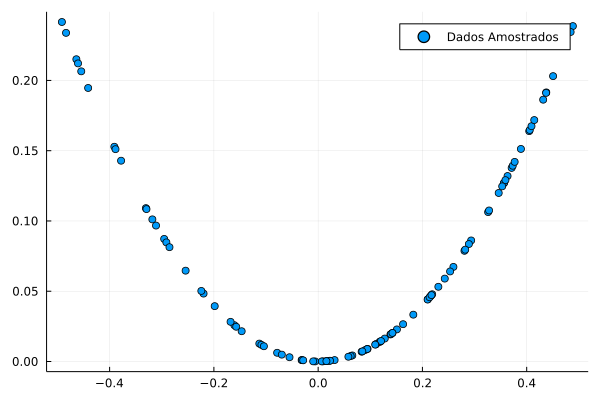

In [307]:
function generate_real_data(n)
    x1 = rand(1,n) .- 0.5
    x2 = x1 .* x1
    return vcat(x1,x2)
end

dados = generate_real_data(100)
x,y = dados[1,:], dados[2,:]
scatter(x,y, label="Dados Amostrados")

### Construindo o Discriminador e o Gerador

In [308]:
function D()
    return Chain(
            Dense(2, 25,relu),
            Dense(25,1)
            )
end

function G(latent_dim::Int)
    return Chain(
            Dense(latent_dim, 15,relu),
            Dense(15,2)
            )
end;


A WGAN busca resolver o seguinte problema de otimização:

$$
\min_{G} W_1(P_{\text{data}},P_g) = \min_{G}
\max_{D \in Lip_1}\mathbb E_{P_{\text{data}}}[D(x)]
-\mathbb E_{P_{g}}[D(x)]
$$

Assim, temos as seguintes funções de perda:

In [434]:
function wasserstein_loss_discr(real,fake, dscr)
    return -mean(dscr(real)) + mean(dscr(fake))
end

function wasserstein_loss_gen(z,gen,dscr)
    return -mean(dscr(gen(z)))
end


wasserstein_loss_gen (generic function with 2 methods)

In [435]:
m = 5
real = generate_real_data(m)
fake = gen(rand(5,m))
# dscr(gen(rand(5)))
# -mean(dscr(real)) + mean(dscr(fake));
# wasserstein_loss_discr(real,fake,dscr)
mean(dscr(real))


-2.478523334831828

#### Vamos descrever a função para treinar a rede $D$.

In [436]:
function trainDiscriminator!(dscr,gen,train_size)
    ps = Flux.params(dscr)
    clip = 0.01
    m = round(Int,train_size)
    for n  in 1:5
        real = generate_real_data(m)
        fake = gen(rand(5,m))
        gs = gradient(Flux.params(dscr)) do
            l = wasserstein_loss_discr(real,fake,dscr)
        end
        Flux.update!(opt, Flux.params(dscr), gs)
        for i in ps
            i = clamp.(i, -clip, clip)
        end
    end
end

# function trainDiscriminator!(dscr,gen,train_size)
#     ps = Flux.params(dscr)
#     clip = 0.01
#     real = generate_real_data(train_size)
#     fake = gen(rand(5,train_size))

#     X    = hcat(real,fake)
#     Y    = vcat(ones(train_size),zeros(train_size))
#     data = Flux.Data.DataLoader((X, Y'), batchsize=1,shuffle=true);
#     for d in data
#         gs = gradient(Flux.params(dscr)) do
#             l = loss_D(d...,dscr)
#         end
#         Flux.update!(opt, Flux.params(dscr), gs)
#         for i in ps
#             i = clamp.(i, -clip, clip)
#         end
#     end
# end


function trainGenerator!(gen,dscr,train_size)
    noise = rand(5,train_size)
    data = Flux.Data.DataLoader(noise, batchsize=128,shuffle=true);
    for d in data
        gs = gradient(Flux.params(gen)) do
            l = wasserstein_loss_gen(d,gen,dscr)
        end
        Flux.update!(opt, Flux.params(gen), gs)
    end
    fake_generated = gen(rand(5,train_size))
end

trainGenerator! (generic function with 1 method)

In [437]:
gen  = G(5)
dscr = D()
opt  = ADAM()
# opt  = RMSProp(0.00005)
train_size = 200

200

In [440]:
epochs = 50000
for e in 1:epochs
    trainDiscriminator!(dscr,gen,Int(train_size))
    trainGenerator!(gen,dscr,train_size)
    if e%1000 == 0
        real = generate_real_data(train_size)
        fake = gen(rand(5,train_size))
        @show mean(dscr(real)),mean(dscr(fake))
    end
end

(mean(dscr(real)), mean(dscr(fake))) = (-3.5256176249703333, -3.132717224830188)
(mean(dscr(real)), mean(dscr(fake))) = (-3.001459440145175, -3.466239621270925)
(mean(dscr(real)), mean(dscr(fake))) = (-3.716269398003439, -4.797406631027017)
(mean(dscr(real)), mean(dscr(fake))) = (-1.4458194830237903, -2.5842308827187956)
(mean(dscr(real)), mean(dscr(fake))) = (-1.0645308387528263, -2.39717396763717)
(mean(dscr(real)), mean(dscr(fake))) = (-4.844717549554029, -8.76075462237749)
(mean(dscr(real)), mean(dscr(fake))) = (-6.360977893201527, -6.733042018027089)
(mean(dscr(real)), mean(dscr(fake))) = (-5.292255627872514, -5.239147492061561)
(mean(dscr(real)), mean(dscr(fake))) = (-5.016802122266967, -3.7928206515258296)
(mean(dscr(real)), mean(dscr(fake))) = (-7.20925781852051, -7.6758149652839345)
(mean(dscr(real)), mean(dscr(fake))) = (-7.2808822365733015, -5.071877798717451)
(mean(dscr(real)), mean(dscr(fake))) = (-12.241154538004977, -9.560025409898909)
(mean(dscr(real)), mean(dscr(fake))

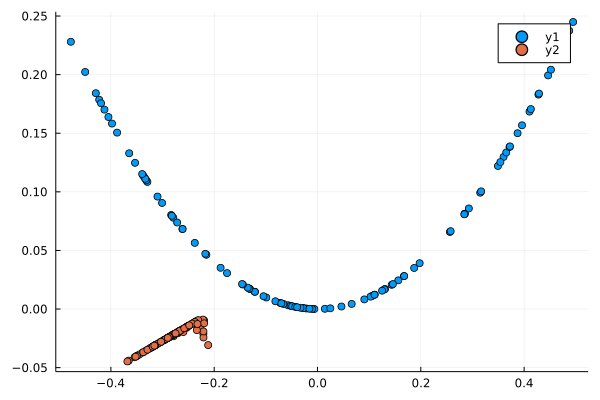

In [441]:
real = generate_real_data(train_size)
fake = gen(rand(5,train_size))
scatter(real[1,1:100],real[2,1:100])
scatter!(fake[1,1:100],fake[2,1:100])